In [123]:
using LinearAlgebra, Statistics, Plots, LaTeXStrings, Distributions, Random, Pkg

In [124]:
using DataFrames, CSV, Lathe ,GLM, Statistics, StatsPlots, MLBase


First let's set the parametes:  
$\rho$=0.95  
$\sigma$=0.007

In [125]:
rho=0.95
sigma=0.007
n=9

9

a) 

Now we'll find the upper and lower bound of the grid, by Tauchen's method.  
$$\theta_N=m\frac{\sigma}{\sqrt{1-\rho^2}}$$  
$$\theta_1=-m\frac{\sigma}{\sqrt{1-\rho^2}}$$
To be conservative I will use m = 3  


In [126]:
m=3
upp=m*sigma/(1-rho^2)^0.5
low=-upp

-0.06725382459813659

Now let's generate equidistant points, as well as the grid "separators", compute the cdfs of the limits we have created for our state spaces, then create the Markov chain transition matrix, this is all done with the function built bellow "tau", and the np.space fuction 

In [127]:
function tau(n,rho,sigma,a,b) 
    xgrid = LinRange(low, upp,n)
    function grid(a,b,n)
        w=((sqrt(b-a))^2)/(n-1)
        x=zeros(n-1)
        x[1]=a+w/2
        x[n-1]=b-w/2
        for i in 2:n-2
            x[i]=x[i-1]+w
        end
    return x
    end
 y=grid(low,upp,n)
    trm = zeros((n, n-1))
    for j in 1:n-1
        for i in 1:n     
            trm[i, j] = cdf.(Normal(rho*xgrid[i],0.007),y[j])
        end
    end    
    trmo=zeros((n,n))
    for i in  1:n 
        trmo[i,1]=trm[i,1]
        trmo[i,n]=1-trm[i,n-1]
        for j in 2:n-1
            trmo[i,j]=trm[i,j]-trm[i,j-1]
        end
    end
 return trmo
end
xgrid = LinRange(low, upp,n)
trmo=tau(9,0.95,007,low,upp)
display(trmo)

9×9 Matrix{Float64}:
 0.764415     0.234688     0.000896597  …  0.0          0.0
 0.0592324    0.740502     0.199673        0.0          0.0
 6.0751e-5    0.0747099    0.756895        0.0          0.0
 4.53698e-10  9.84423e-5   0.0931427       1.11022e-16  0.0
 2.10804e-17  9.57805e-10  0.000157352     9.57805e-10  0.0
 5.7576e-27   5.82502e-17  1.99377e-9   …  9.84423e-5   4.53698e-10
 9.0067e-39   2.08649e-26  1.58686e-16     0.0747099    6.0751e-5
 7.9581e-53   4.28473e-38  7.45388e-26     0.740502     0.0592324
 3.93893e-69  4.9727e-52   2.00935e-37     0.234688     0.764415

b)
The Rouwenhorst's method is based on a different grid and matrix using the following logic:

$$\theta_N=\sigma_\theta \sqrt{N-1} \quad \theta_1=-\theta_N \quad where \quad \sigma_\theta^2=\frac{\sigma^2}{1-\rho^2}$$


$$
P_N=p\left[\begin{array}{cc}
P_{N-1} & 0 \\
\mathbf{0}^{\prime} & 0
\end{array}\right]+(1-p)\left[\begin{array}{cc}
\mathbf{0} & P_{N-1} \\
0 & \mathbf{0}^{\prime}
\end{array}\right]+(1-p)\left[\begin{array}{cc}
\mathbf{0}^{\prime} & 0 \\
P_{N-1} & \mathbf{0}
\end{array}\right]+p\left[\begin{array}{cc}
0 & \mathbf{0}^{\prime} \\
\mathbf{0} & P_{N-1}
\end{array}\right]
$$
$$p=\frac{1+\rho}{2}, P_2=\left[\begin{array}{cc}p & 1-p \\ 1-p & p\end{array}\right]$$


In [128]:
function rouwenhorst(n, rho,sigma)
    p = (1 + rho) / 2
    maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
    if n <= 2
        return  [p 1-p; 1-p p]
    else
         thetaprev = rouwenhorst(n-1, rho, sigma)
         theta = p    *[thetaprev zeros(n-1, 1); zeros(1, n)] +
         (1-p)*[zeros(n-1, 1) thetaprev; zeros(1, n)] +
         p    *[zeros(1, n); zeros(n-1, 1) thetaprev] +
         (1-p)*[zeros(1, n); thetaprev zeros(n-1, 1)]
    end
    for i in 1:n
        theta[i,1:n]=theta[i,1:n]/sum(theta[i,1:n])
    end
return theta    
end
trm1 =rouwenhorst(n, rho,sigma)
 maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
xgrid1=LinRange(mini, maxi,n)

9-element LinRange{Float64, Int64}:
 -0.0634075,-0.0475556,-0.0317038,-0.0158519,…,0.0317038,0.0475556,0.0634075

c)

Now we can simulate the process, starting with the continuous one to get its shocks:

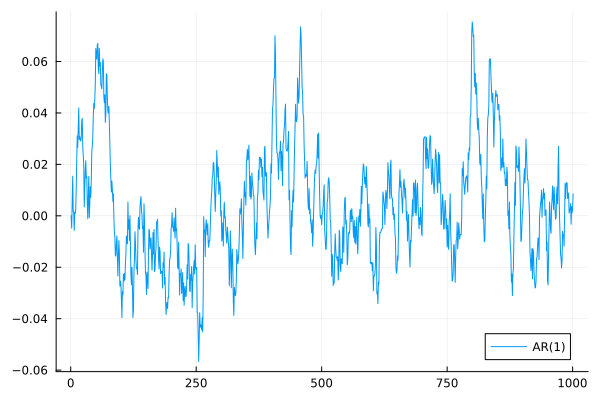

In [137]:
Random.seed!(162)
d = Normal(0.0, 0.007)
shocks=rand(d, 1000)
x=zeros(1001)
x[1]=0
alpha=0.95
T=999
for t in 1:1000
    x[t+1]=x[t]*alpha + shocks[t]  
end
plot(x, label="AR(1)")

We then get the cdf of the shocks, and choose the next state if the process in the discrete case as the first one that the sum of the transition matrix of the current step (starting from the left)

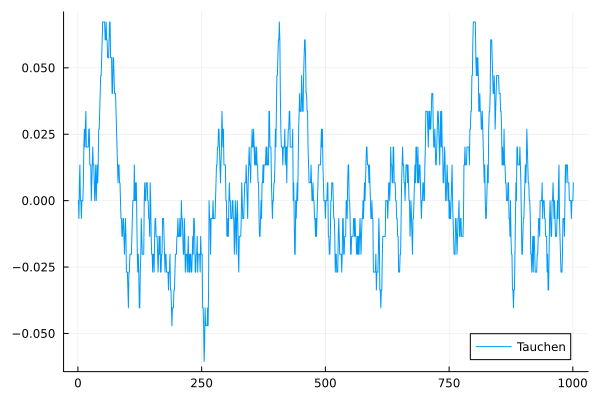

In [138]:
z=cdf.(Normal(0,0.007),shocks)
current_state=zeros(1001)
current_state[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trmo[Int(current_state[i]),1:n]), z[i])
end
states=zeros(1001)
states[1]=0
for i in 2:1001
states[i]=xgrid[Int(current_state[i])]
end
plot(states, label="Tauchen")


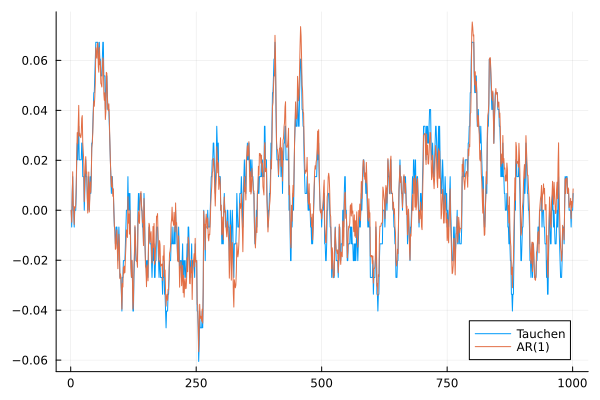

In [139]:
plot(states, label="Tauchen")
plot!(x, label="AR(1)")

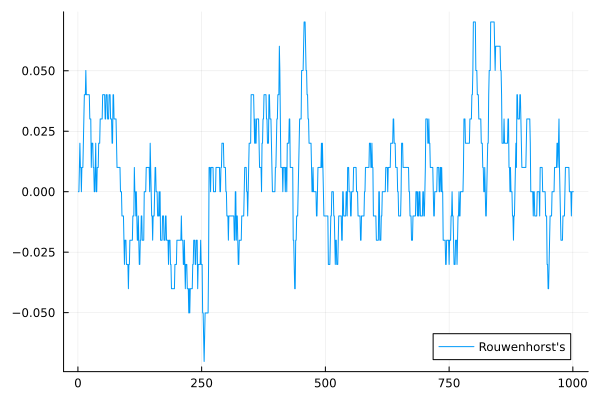

In [149]:
z=cdf.(Normal(0,0.007),shocks)
current_state1=zeros(1001)
current_state1[1]=(n+1)/2
for i in 1:1000
    current_state1[i+1]=searchsortedfirst(cumsum(trm1[Int(current_state1[i]),1:n]), z[i])
end
states1=zeros(1001)
states1[1]=0
for i in 2:1001
states1[i]=xgrid1[Int(current_state[i])]
end
plot(states1, label="Rouwenhorst's")

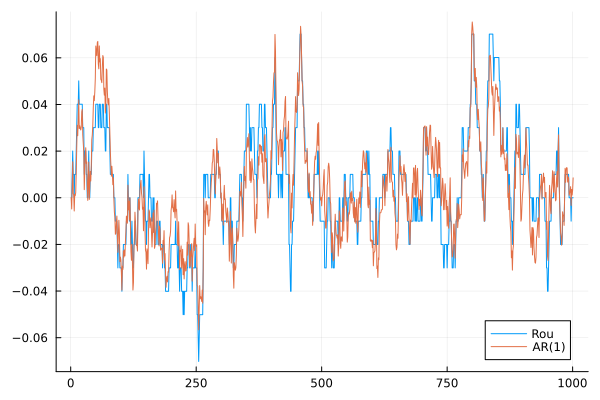

In [150]:
plot(states1, label="Rou")
plot!(x, label="AR(1)")

they both seem close lets try with n=21

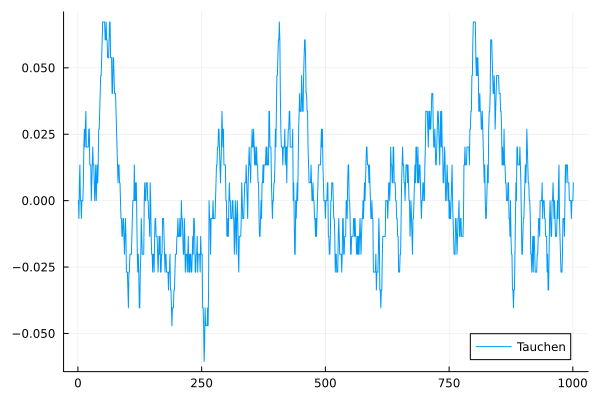

In [151]:
n=21
xgrid = LinRange(low, upp,n)
trmo=tau(n,0.95,007,low,upp)
z=cdf.(Normal(0,0.007),shocks)
current_state=zeros(1001)
current_state[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trmo[Int(current_state[i]),1:n]), z[i])
end
states=zeros(1001)
states[1]=0
for i in 2:1001
states[i]=xgrid[Int(current_state[i])]
end
plot(states, label="Tauchen")

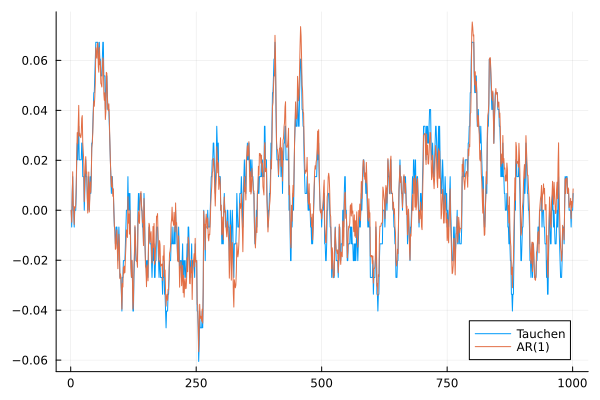

In [152]:
plot(states, label="Tauchen")
plot!(x, label="AR(1)")

way closer, lets try rou 

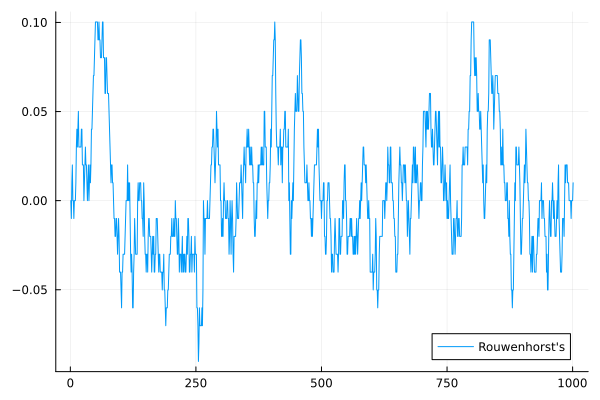

In [154]:
n=21
trm1 =rouwenhorst(n, rho,sigma)
 maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
xgrid1=LinRange(mini, maxi,n)
current_state1=zeros(1001)
current_state1[1]=(n+1)/2
for i in 1:1000
    current_state1[i+1]=searchsortedfirst(cumsum(trm1[Int(current_state1[i]),1:n]), z[i])
end
states1=zeros(1001)
states1[1]=0
for i in 2:1001
states1[i]=xgrid1[Int(current_state[i])]
end
plot(states1, label="Rouwenhorst's")

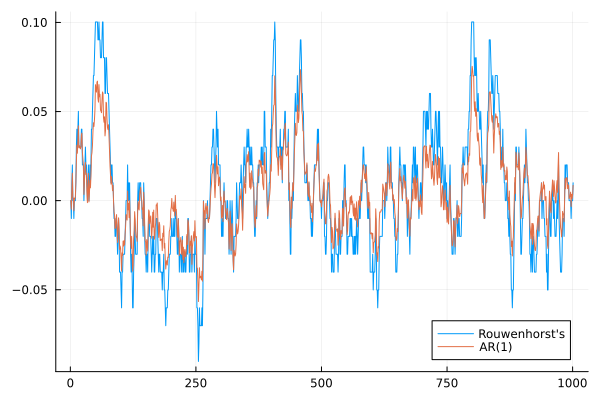

In [156]:
plot(states1, label="Rouwenhorst's")
plot!(x, label="AR(1)")

d)  
 let's now try the regressions, first with n=9 for Tauchen's and Rouwenhorst's methods respectivly

In [157]:
n=9
xgrid = LinRange(low, upp,n)
trmo=tau(n,0.95,007,low,upp)
z=cdf.(Normal(0,0.007),shocks)
current_state=zeros(1001)
current_state[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trmo[Int(current_state[i]),1:n]), z[i])
end
states=zeros(1001)
states[1]=0
for i in 2:1001
states[i]=xgrid[Int(current_state[i])]
end
data=DataFrame(X=states[1:1000],Y=states[2:1001])
ols=lm(@formula(Y~X),data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error      t  Pr(>|t|)     Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000253162  0.000270247   0.94    0.3491  -0.000277155  0.00078348
X            0.948319     0.0100536    94.33    <1e-99   0.928591     0.968048
────────────────────────────────────────────────────────────────────────────────

That got us a really good result, let's ckeck Rouwenhorst's

In [159]:
trm1 =rouwenhorst(n, rho,sigma)
 maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
xgrid1=LinRange(mini, maxi,n)
current_state1=zeros(1001)
current_state1[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trm1[Int(current_state[i]),1:n]), z[i])
end
states1=zeros(1001)
states1[1]=0
for i in 2:1001
states1[i]=xgrid1[Int(current_state[i])]
end
data=DataFrame(X=states1[1:1000],Y=states1[2:1001])
ols=lm(@formula(Y~X),data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000357398  0.000234663   1.52    0.1281  -0.00010309  0.000817887
X            0.948116     0.0101242    93.65    <1e-99   0.928249    0.967983
────────────────────────────────────────────────────────────────────────────────

it also did pretty good, let's try with n=21 

In [160]:
n=21
xgrid = LinRange(low, upp,n)
trmo=tau(n,0.95,007,low,upp)
z=cdf.(Normal(0,0.007),shocks)
current_state=zeros(1001)
current_state[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trmo[Int(current_state[i]),1:n]), z[i])
end
states=zeros(1001)
states[1]=0
for i in 2:1001
states[i]=xgrid[Int(current_state[i])]
end
data=DataFrame(X=states[1:1000],Y=states[2:1001])
ols=lm(@formula(Y~X),data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000186644  0.000236377   0.79    0.4299  -0.000277209  0.000650496
X            0.947338     0.0101368    93.46    <1e-99   0.927447     0.96723
─────────────────────────────────────────────────────────────────────────────────

In [161]:
trm1 =rouwenhorst(n, rho,sigma)
 maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
xgrid1=LinRange(mini, maxi,n)
current_state1=zeros(1001)
current_state1[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trm1[Int(current_state[i]),1:n]), z[i])
end
states1=zeros(1001)
states1[1]=0
for i in 2:1001
states1[i]=xgrid1[Int(current_state[i])]
end
data=DataFrame(X=states1[1:1000],Y=states1[2:1001])
ols=lm(@formula(Y~X),data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.00019264  0.000232018   0.83    0.4066  -0.000262659  0.000647938
X            0.952439    0.00964607   98.74    <1e-99   0.93351      0.971368
────────────────────────────────────────────────────────────────────────────────

they did very weel with a larger n aswell

now let's do it all again with rho =0.99

In [163]:
rho=0.99
sigma=0.007
n=9

9

In [164]:
m=3
upp=m*sigma/(1-rho^2)^0.5
low=-upp
xgrid = LinRange(low, upp,n)
trmo=tau(n,rho,007,low,upp)

9×9 Matrix{Float64}:
 0.99277       0.00722976    4.21885e-15   …  0.0          0.0
 0.00241767    0.991352      0.00623062       0.0          0.0
 3.20542e-16   0.00284931    0.991795         0.0          0.0
 6.36004e-41   4.95051e-16   0.00334927       0.0          0.0
 1.38039e-77   1.29624e-40   7.62438e-16      0.0          0.0
 3.02319e-126  3.71775e-77   2.63446e-40   …  4.44089e-16  0.0
 6.46715e-187  1.07648e-125  9.9847e-77       0.00284931   3.33067e-16
 1.32937e-259  3.04516e-186  3.82225e-125     0.991352     0.00241767
 0.0           8.27854e-259  1.42982e-185     0.00722976   0.99277

In [165]:
trm1 =rouwenhorst(n, rho,sigma)
 maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
xgrid1=LinRange(mini, maxi,n)
trm1

9×9 Matrix{Float64}:
 0.960693     0.0386208    0.000679261  …  6.21875e-16  3.90625e-19
 0.0048276    0.960863     0.0337958       1.08284e-13  7.77344e-17
 2.42593e-5   0.00965594   0.960984        1.84703e-11  1.54691e-14
 1.21906e-7   7.2781e-5    0.0144846       3.06301e-9   3.07836e-12
 6.12593e-10  4.87637e-7   0.000145566     4.87637e-7   6.12593e-10
 3.07836e-12  3.06301e-9   1.21911e-6   …  7.2781e-5    1.21906e-7
 1.54691e-14  1.84703e-11  9.18909e-9      0.00965594   2.42593e-5
 7.77344e-17  1.08284e-13  6.46461e-11     0.960863     0.0048276
 3.90625e-19  6.21875e-16  4.33136e-13     0.0386208    0.960693

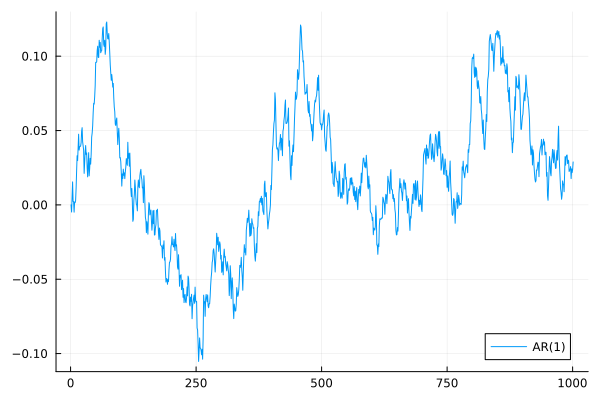

In [168]:
Random.seed!(162)
d = Normal(0.0, 0.007)
shocks=rand(d, 1000)
x=zeros(1001)
x[1]=0
alpha=0.99
T=999
for t in 1:1000
    x[t+1]=x[t]*alpha + shocks[t]  
end
plot(x,label="AR(1)")

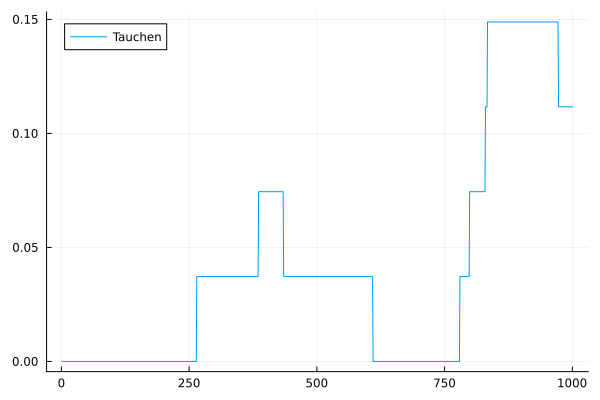

In [169]:
current_state=zeros(1001)
current_state[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trmo[Int(current_state[i]),1:n]), z[i])
end
states=zeros(1001)
states[1]=0
for i in 2:1001
states[i]=xgrid[Int(current_state[i])]
end
plot(states, label="Tauchen")

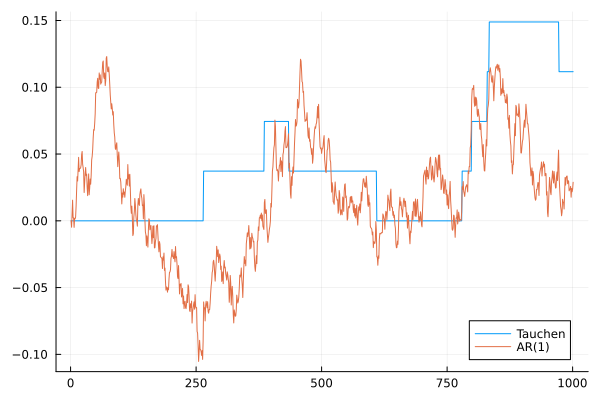

In [170]:
plot(states, label="Tauchen")
plot!(x, label="AR(1)")

this is obviosly terrible, let's try Rouwenhorst'S

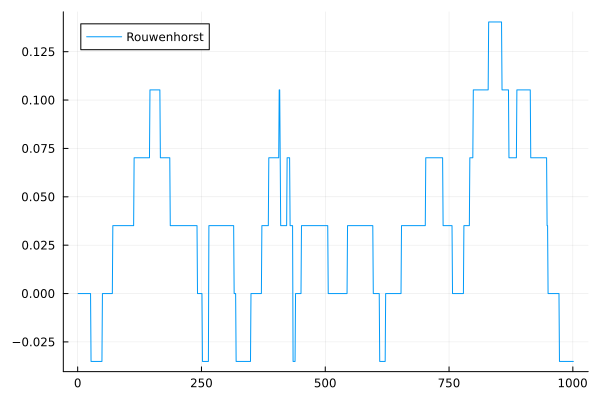

In [171]:
current_state1=zeros(1001)
current_state1[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trm1[Int(current_state[i]),1:n]), z[i])
end
states1=zeros(1001)
states1[1]=0
for i in 2:1001
states1[i]=xgrid1[Int(current_state[i])]
end
plot(states1, label="Rouwenhorst")

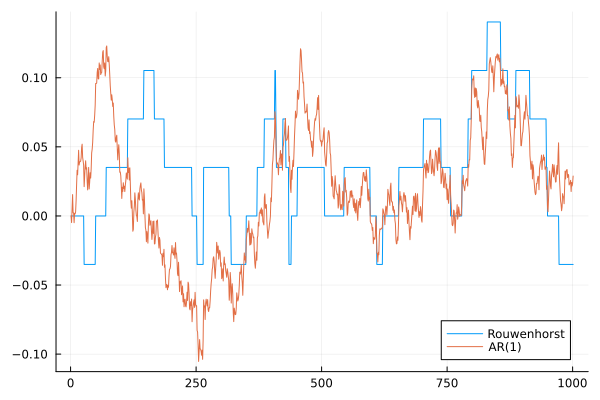

In [173]:
plot(states1, label="Rouwenhorst")
plot!(x, label="AR(1)")

it dosnt do very well either,thought a litlle better, let's try for a bigeer n

In [174]:
rho=0.99
sigma=0.007
n=61

61

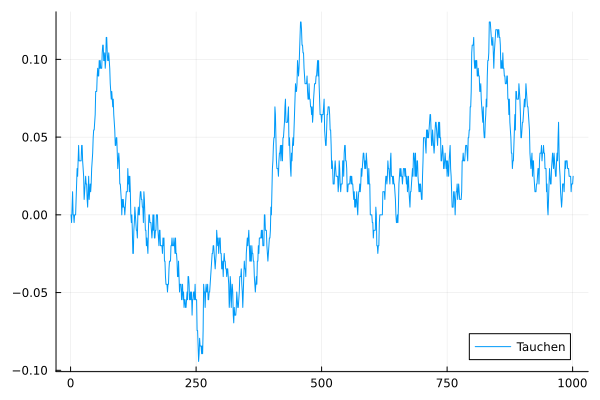

In [176]:
m=3
upp=m*sigma/(1-rho^2)^0.5
low=-upp
xgrid = LinRange(low, upp,n)
trmo=tau(n,rho,007,low,upp)
current_state=zeros(1001)
current_state[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trmo[Int(current_state[i]),1:n]), z[i])
end
states=zeros(1001)
states[1]=0
for i in 2:1001
states[i]=xgrid[Int(current_state[i])]
end
plot(states,  label="Tauchen")

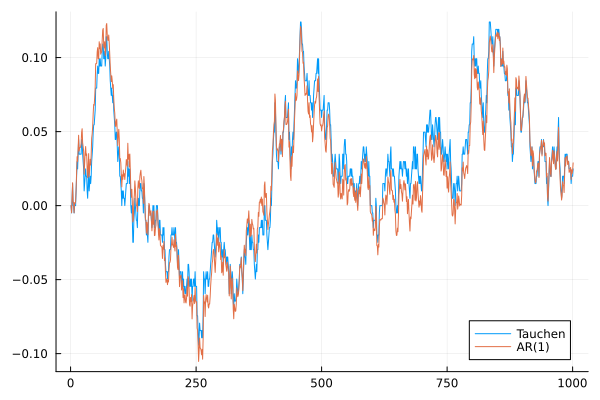

In [177]:
plot(states, label="Tauchen")
plot!(x, label="AR(1)")

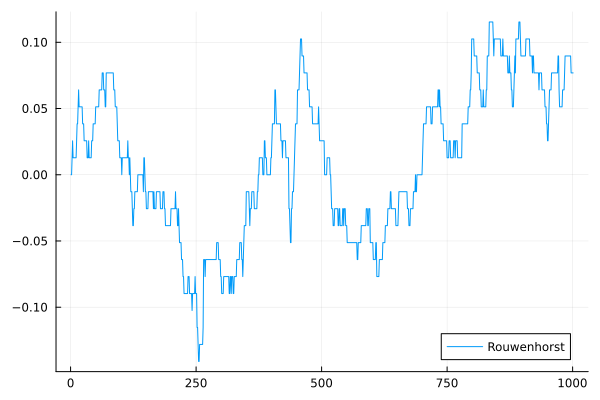

In [178]:
trm1 =rouwenhorst(n, rho,sigma)
 maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
xgrid1=LinRange(mini, maxi,n)
current_state1=zeros(1001)
current_state1[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trm1[Int(current_state[i]),1:n]), z[i])
end
states1=zeros(1001)
states1[1]=0
for i in 2:1001
states1[i]=xgrid1[Int(current_state[i])]
end
plot(states1, label="Rouwenhorst")

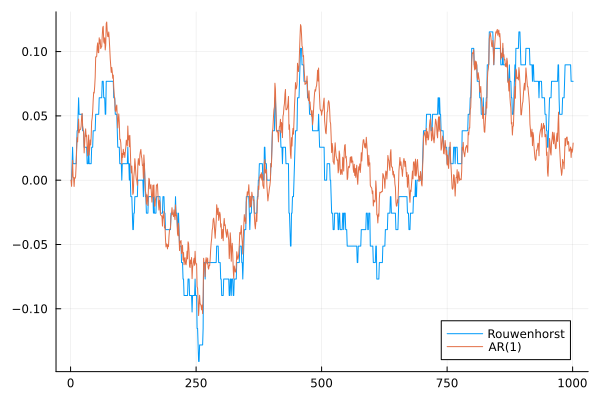

In [180]:
plot(states1, label="Rouwenhorst")
plot!(x, label="AR(1)")

they both loock way better, let's check the regressions for Tauchen's Rouwenhorst's methods respectivly

In [181]:
n=9
upp=m*sigma/(1-rho^2)^0.5
low=-upp
xgrid = LinRange(low, upp,n)
trmo=tau(n,rho,007,low,upp)
z=cdf.(Normal(0,0.007),shocks)
current_state=zeros(1001)
current_state[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trmo[Int(current_state[i]),1:n]), z[i])
end
states=zeros(1001)
states[1]=0
for i in 2:1001
states[i]=xgrid[Int(current_state[i])]
end
data=DataFrame(X=states[1:1000],Y=states[2:1001])
ols=lm(@formula(Y~X),data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000187205  0.000144596    1.29    0.1957  -9.6542e-5  0.000470951
X            0.998199     0.00219015   455.77    <1e-99   0.993901   1.0025
────────────────────────────────────────────────────────────────────────────────

In [182]:
trm1 =rouwenhorst(n, rho,sigma)
 maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
xgrid1=LinRange(mini, maxi,n)
current_state1=zeros(1001)
current_state1[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trm1[Int(current_state[i]),1:n]), z[i])
end
states1=zeros(1001)
states1[1]=0
for i in 2:1001
states1[i]=xgrid1[Int(current_state[i])]
end
data=DataFrame(X=states1[1:1000],Y=states1[2:1001])
ols=lm(@formula(Y~X),data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)     Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000513453  0.000317265    1.62    0.1059  -0.000109131  0.00113604
X            0.98432      0.00576382   170.78    <1e-99   0.973009     0.99563
─────────────────────────────────────────────────────────────────────────────────

Now for n=61, in the same order

In [185]:
n=61
xgrid = LinRange(low, upp,n)
trmo=tau(n,rho,007,low,upp)
z=cdf.(Normal(0,0.007),shocks)
current_state=zeros(1001)
current_state[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trmo[Int(current_state[i]),1:n]), z[i])
end
states=zeros(1001)
states[1]=0
for i in 2:1001
states[i]=xgrid[Int(current_state[i])]
end
data=DataFrame(X=states[1:1000],Y=states[2:1001])
ols=lm(@formula(Y~X),data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000337606  0.000260862    1.29    0.1959  -0.000174295  0.000849507
X            0.986752     0.00510901   193.14    <1e-99   0.976726     0.996777
──────────────────────────────────────────────────────────────────────────────────

In [186]:
trm1 =rouwenhorst(n, rho,sigma)
 maxi = (sigma^2 / (1 - rho^2))^(1/2) *sqrt(n - 1)
    mini=-maxi
xgrid1=LinRange(mini, maxi,n)
current_state1=zeros(1001)
current_state1[1]=(n+1)/2
for i in 1:1000
    current_state[i+1]=searchsortedfirst(cumsum(trm1[Int(current_state[i]),1:n]), z[i])
end
states1=zeros(1001)
states1[1]=0
for i in 2:1001
states1[i]=xgrid1[Int(current_state[i])]
end
data=DataFrame(X=states1[1:1000],Y=states1[2:1001])
ols=lm(@formula(Y~X),data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000154225  0.000235412    0.66    0.5125  -0.000307733  0.000616184
X            0.9922       0.0041176    240.97    <1e-99   0.98412      1.00028
──────────────────────────────────────────────────────────────────────────────────

they both did pretty well